## **Identify Bengali Handwritten Digits**

- **Dataset**
    - [NumtaDB: Bengali Handwritten Digits](https://www.kaggle.com/BengaliAI/numta/)
- **Train data set 90%**
-**Test data set 10%**

**Install dependencies**

In [ ]:

!pip install kaggle

**Kaggle User API Import** 

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mdzahidfesabelilla","key":"4cbf3deb9ef668a2834a53c5259e67e1"}'}

**Change file access permission** 

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#change permission
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
 !kaggle datasets download -d BengaliAI/numta

100% 1.90G/1.91G [00:18<00:00, 57.5MB/s]
100% 1.91G/1.91G [00:18<00:00, 110MB/s] 


**Unzip Dataset**

In [ ]:
from zipfile import ZipFile
fileName = "numta.zip"

with ZipFile(fileName,'r') as zip:
  zip.extractall()
  print('Done')


Done


**Show 'training-a.csv' file first top 5 row**

In [ ]:
import pandas as pd
df = pd.read_csv('training-a.csv')
df.head()


,filename,original filename,scanid,digit,database name original,contributing team,database name
0,a00000.png,Scan_58_digit_5_num_8.png,58,5,BHDDB,Buet_Broncos,training-a
1,a00001.png,Scan_73_digit_3_num_5.png,73,3,BHDDB,Buet_Broncos,training-a
2,a00002.png,Scan_18_digit_1_num_3.png,18,1,BHDDB,Buet_Broncos,training-a
3,a00003.png,Scan_166_digit_7_num_3.png,166,7,BHDDB,Buet_Broncos,training-a
4,a00004.png,Scan_108_digit_0_num_1.png,108,0,BHDDB,Buet_Broncos,training-a


In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
PATH = '/content/'
os.listdir(PATH)

['.config',
 'training-e',
 'testing-d',
 'training-a.csv',
 'kaggle.json',
 'training-e.csv',
 'testing-all-corrected',
 'training-c',
 'training-d.csv',
 'numta.zip',
 'training-d',
 'testing-e',
 'testing-auga',
 'training-b.csv',
 'testing-augc',
 'testing-c',
 'testing-f',
 'testing-b',
 'training-c.csv',
 'training-b',
 'testing-a',
 'training-a',
 'sample_data']

In [ ]:
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(PATH + csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

**Show all column name**

In [ ]:
a_csv = showRawTrainingSamples('training-a.csv')
c_csv = showRawTrainingSamples('training-c.csv')

training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')


**Useless column drop**

In [ ]:
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

In [ ]:
a_csv = dropColumns(a_csv)
c_csv = dropColumns(c_csv)

         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0
         filename  digit
0      c00000.png      6
1      c00001.png      1
2      c00002.png      3
3      c00003.png      2
4      c00004.png      7
...           ...    ...
24293  c24293.png      3
24294  c24294.png      2
24295  c24295.png      7
24296  c24296.png      2
24297  c24297.png      7

[24298 rows x 2 columns]
     filename  digit
0  c00000.png      6
1  c00001.png      1
2  c00002.png      3
3  c00003.png      2
4  c00004.png      7


In [ ]:
total_csv = [a_csv, c_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

44000


In [ ]:
TRAIN_PATH = 'train'
os.mkdir(TRAIN_PATH)

**Data process and store them in 'training-a' and 'training-c' directory**

In [ ]:
def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

In [ ]:
processImages('training-a')
print('A Done')
processImages('training-c')
print('C Done')

A Done
C Done


In [ ]:
###################
# Settings01
###################

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L')
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

**Inspecting a single image (28 pixel x 28 pixel) 28x28 matrix of numbers** 


In [ ]:
mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Trainig Samples: ",len(train_data))



Trainig Samples:  44000


In [ ]:
# Hyperparameters

batch_size = 100
num_iters = 6000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.1  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

**Split data 10% for testing and 90% for traning**

In [ ]:
#batch size


# split data 10% for testing
test_size = 0.1

# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))


Train dataloader:396
Test dataloader:44


In [ ]:
print(len(train_sampler))
print(len(test_sampler))

39600
4400


In [ ]:
# One Image Size
print(train_data[0][0].size())
print(train_data[0][0].numpy().shape)
# First Image Label
print(train_data[0][1])

torch.Size([1, 28, 28])
(1, 28, 28)
5


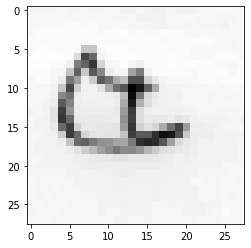

In [ ]:
## Displaying a  Image

import matplotlib.pyplot as plt 
import numpy as np

show_img = train_data[0][0].numpy().reshape(28, 28)
plt.imshow(show_img, cmap='gray')

#**Settings #1**

*   **Batch Size = 100**
*   **Number of iterations = 6000**
*   **Learning Rate = 0.1**
*   **Num of Hidden Nodes = 100**



In [ ]:
# Hyperparameters

batch_size = 100
num_iters = 6000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.1  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer
        self.linear_1 = nn.Linear(input_size, num_hidden)

        ### Non-linearity
        self.sigmoid = nn.Sigmoid()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        # Non-linearity
        out = self.sigmoid(out)
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

In [ ]:
'''
INSTANTIATE MODEL CLASS
'''
model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

NeuralNetworkModel(
  (linear_1): Linear(in_features=784, out_features=100, bias=True)
  (sigmoid): Sigmoid()
  (linear_out): Linear(in_features=100, out_features=10, bias=True)
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)

In [ ]:
num_epochs

13

In [ ]:
'''
TRAIN THE MODEL
'''
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2920312881469727. Accuracy: 16.40909090909091
Iteration: 1000. Loss: 2.170316696166992. Accuracy: 18.568181818181817
Iteration: 1500. Loss: 2.132253646850586. Accuracy: 26.34090909090909
Iteration: 2000. Loss: 2.1019535064697266. Accuracy: 29.09090909090909
Iteration: 2500. Loss: 2.1396636962890625. Accuracy: 27.59090909090909
Iteration: 3000. Loss: 1.9754273891448975. Accuracy: 30.272727272727273
Iteration: 3500. Loss: 2.0482850074768066. Accuracy: 39.29545454545455
Iteration: 4000. Loss: 1.8811314105987549. Accuracy: 31.318181818181817
Iteration: 4500. Loss: 1.953782558441162. Accuracy: 38.31818181818182
Iteration: 5000. Loss: 1.8355412483215332. Accuracy: 34.29545454545455


#**Settings #2**
## One Layer Neural Network with Tanh Activation

*   **Batch Size = 100**
*   **Number of iterations = 6000**
*   **Learning Rate = 0.1**
*   **Num of Hidden Nodes = 100**

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 100
num_iters = 6000
input_dim = 28*28 # num_features = 784
num_hidden = 100
output_dim = 10

learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


class NeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer
        self.linear_1 = nn.Linear(input_size, num_hidden)

        ### Non-linearity
        self.tanh = nn.Tanh()

        ### Output layer
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        # Linear layer
        out  = self.linear_1(x)
        # Non-linearity
        out = self.tanh(out)
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

model = NeuralNetworkModel(input_size = input_dim,
                           num_classes = output_dim,
                           num_hidden = num_hidden)
# To enable GPU
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.2902626991271973. Accuracy: 14.272727272727273
Iteration: 1000. Loss: 2.3950181007385254. Accuracy: 27.681818181818183
Iteration: 1500. Loss: 2.1109366416931152. Accuracy: 29.681818181818183
Iteration: 2000. Loss: 1.9819968938827515. Accuracy: 34.59090909090909
Iteration: 2500. Loss: 1.9994041919708252. Accuracy: 17.568181818181817
Iteration: 3000. Loss: 1.7036455869674683. Accuracy: 33.79545454545455
Iteration: 3500. Loss: 1.9135069847106934. Accuracy: 18.59090909090909
Iteration: 4000. Loss: 1.7918367385864258. Accuracy: 39.13636363636363
Iteration: 4500. Loss: 1.8387701511383057. Accuracy: 28.136363636363637
Iteration: 5000. Loss: 1.807010531425476. Accuracy: 38.61363636363637


#**Settings #3**
## Two Layer Neural Network (Deep) with ReLU Activation
*   **Batch Size = 100**
*   **Number of iterations = 6000**
*   **Learning Rate = 0.1**
*   **Num of Hidden Nodes = 200**


## Two Layer Neural Network (Deep) with ReLU Activation

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 100
num_iters = 6000
input_dim = 28*28 # num_features = 784
num_hidden = 200
output_dim = 10

learning_rate = 0.1

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels. cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.267613649368286. Accuracy: 21.09090909090909
Iteration: 1000. Loss: 2.067176580429077. Accuracy: 17.84090909090909
Iteration: 1500. Loss: 2.2078659534454346. Accuracy: 22.636363636363637
Iteration: 2000. Loss: 2.1550557613372803. Accuracy: 19.295454545454547
Iteration: 2500. Loss: 2.0629470348358154. Accuracy: 25.977272727272727
Iteration: 3000. Loss: 2.10848331451416. Accuracy: 26.977272727272727
Iteration: 3500. Loss: 1.9685627222061157. Accuracy: 32.06818181818182
Iteration: 4000. Loss: 2.033245801925659. Accuracy: 28.0
Iteration: 4500. Loss: 1.9097845554351807. Accuracy: 34.22727272727273
Iteration: 5000. Loss: 1.7264344692230225. Accuracy: 30.045454545454547


#**Settings #4**
## Three Layer Neural Network (Deep) with ReLU Activation
*   **Batch Size = 100**
*   **Number of iterations = 6000**
*   **Learning Rate = 0.01**
*   **Num of Hidden Nodes = 250**


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

# Hyperparameters
batch_size = 100
num_iters = 6000
input_dim = 28*28 #num_features = 784
num_hidden = 250
output_dim = 10

learning_rate = 0.01

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)



class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.relu_1 = nn.ReLU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.relu_2 = nn.ReLU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.relu_3 = nn.ReLU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.relu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.relu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.relu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas

# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)

# INSTANTIATE LOSS & OPTIMIZER CLASS
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total

            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.300567388534546. Accuracy: 10.636363636363637
Iteration: 1000. Loss: 2.301452875137329. Accuracy: 12.977272727272727
Iteration: 1500. Loss: 2.2952303886413574. Accuracy: 12.363636363636363
Iteration: 2000. Loss: 2.28908109664917. Accuracy: 20.15909090909091
Iteration: 2500. Loss: 2.290834426879883. Accuracy: 18.272727272727273
Iteration: 3000. Loss: 2.2820889949798584. Accuracy: 14.568181818181818
Iteration: 3500. Loss: 2.269426107406616. Accuracy: 21.59090909090909
Iteration: 4000. Loss: 2.1864235401153564. Accuracy: 20.863636363636363
Iteration: 4500. Loss: 2.1024560928344727. Accuracy: 24.681818181818183
Iteration: 5000. Loss: 2.0674407482147217. Accuracy: 25.15909090909091


**Result Table:-**

| Settings #1      | Settings #2     | Settings #3     | Settings #4     |
| :------------- | :----------: | -----------: | -----------: |
|  Batch Size = 100 | Batch Size = 100  | Batch Size = 100    |Batch Size = 100    |
|  Number of iterations = 6000 | Number of iterations = 6000   | Number of iterations = 6000    | Number of iterations = 6000    |
|  Learning Rate = 0.1 | Learning Rate = 0.1   | Learning Rate = 0.1 |Learning Rate = 0.01 |
|Num of Hidden Nodes = 100|Num of Hidden Nodes = 100|Num of Hidden Nodes = 200|Num of Hidden Nodes = 250|
| Accuracy : 34.30  | Accuracy : 38.61 | Accuracy : 30.04 |Accuracy : 25.16 | |
